In [132]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [134]:
import bnn.functions
import bnn.network
import bnn.layer
import bnn.loss
import bnn.optimizer

In [135]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [136]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [137]:
dims = [1, 10, 4]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=forward_func,
    backward_func=backward_func,
)

In [138]:
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [139]:
samples = 100
input = bnn.functions.binarise(torch.randn(samples, 1).to(torch.int))
desired = torch.stack(
    [input[..., 0], -input[..., 0], torch.ones(samples, dtype=torch.int), -torch.ones(samples, dtype=torch.int)], dim=-1
)
desired.shape

torch.Size([100, 4])

In [140]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [141]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.0001)

In [142]:
losses = []

In [143]:
initial_train_epochs = 50

In [144]:
for epoch in range(initial_train_epochs):
    # forward pass
    output = TBNN.forward(input)
    loss = loss_func.forward(output=output, target=desired)
    losses.append(loss)

    # backward pass
    grad = loss_func.backward(output=output, target=desired)
    out_grad = TBNN.backward(grad)

    # optimizer step
    BernOpt.step(number_of_samples=len(input))

    early_exit = loss == 0

    if early_exit or (epoch % 10) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

epoch: 0	loss: 536
epoch: 10	loss: 536
epoch: 20	loss: 368
epoch: 30	loss: 200
epoch: 40	loss: 200


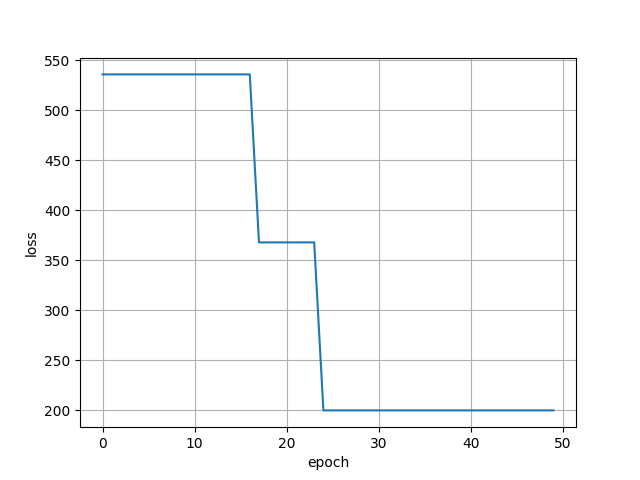

In [145]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:initial_train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [146]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1,  0,  0,  0]], dtype=torch.int32) 
 tensor([[0, 0, 0, 0]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[-1, -1,  0, -1],
        [ 0, -1,  0,  0],
        [ 0,  0,  1, -1],
        [ 0,  0,  1, -1]], dtype=torch.int32) 
 tensor([[   0, -100,    0,    0],
        [   0,   68,    0,    0],
        [   0,   68,    0,    0],
        [   0,   68,    0,    0]], dtype=torch.int32)


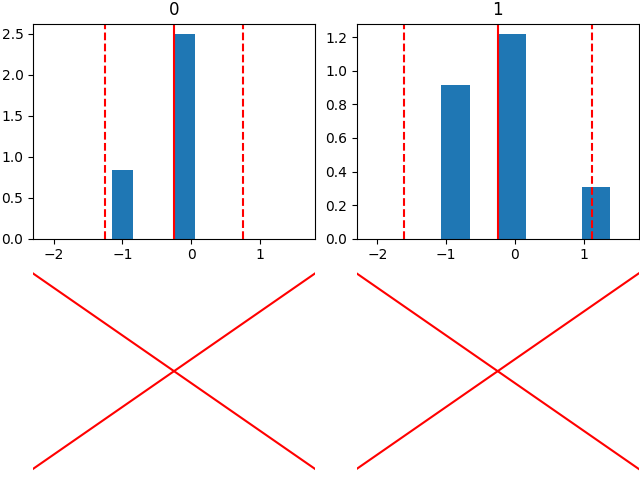

In [147]:
FIG_NAME = "W distribution1"
plt.close(FIG_NAME)

data = [layer.W for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

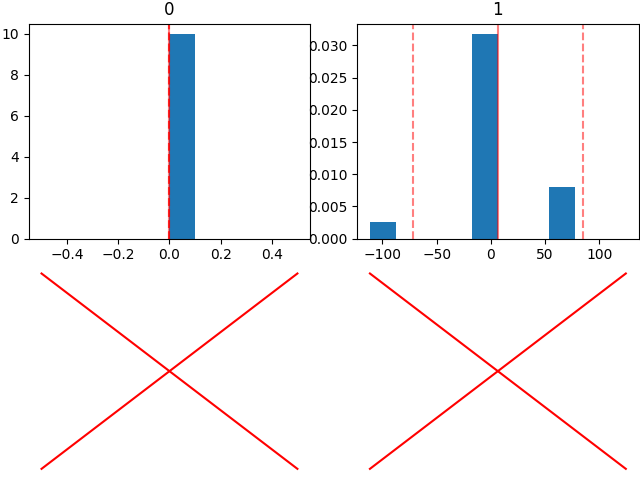

In [148]:

FIG_NAME = "W_grad distribution1"
plt.close(FIG_NAME)

data = [layer.W.grad for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-", alpha=0.5)
        ax.axvline(mean+2*std, color="red", ls="--", alpha=0.5)
        ax.axvline(mean-2*std, color="red", ls="--", alpha=0.5)


for ax in axs:
    #ax.set_xlim(min_x, max_x)
    pass
        

fig.tight_layout(pad=0.1)

plt.show()

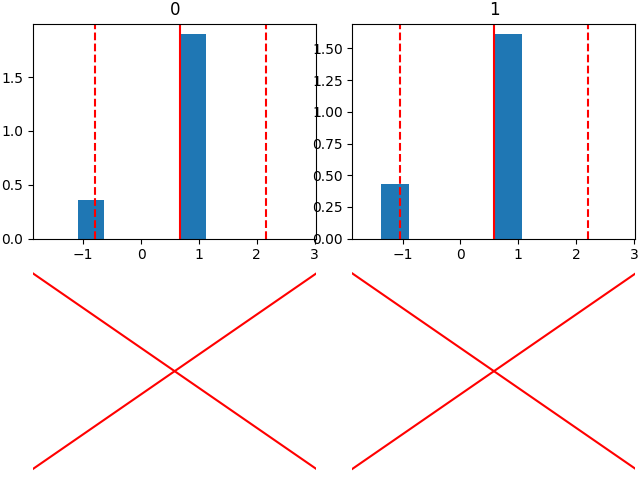

In [149]:
FIG_NAME = "activation distribution1"
plt.close(FIG_NAME)

data = TBNN.input.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.flatten().to(torch.float)
        if len(datum_float) > 1:
            mean = datum_float.mean().item()
            std = datum_float.std().item()
        else:
            mean = datum_float[0].item()
            std = 0

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

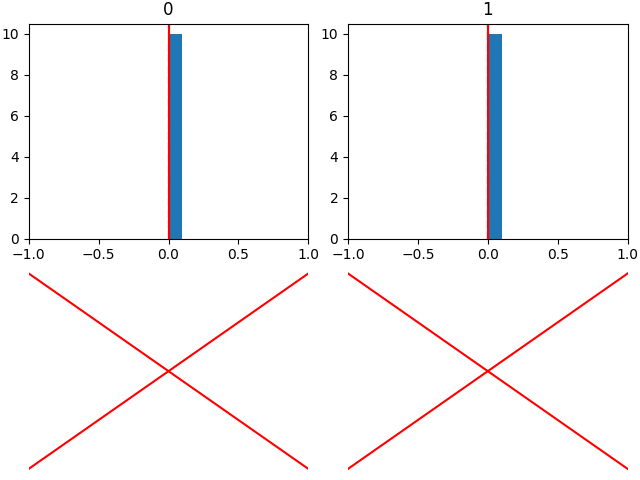

In [150]:

FIG_NAME = "grad distribution1"
plt.close(FIG_NAME)

data = TBNN.grad.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.flatten().to(torch.float)
        if len(datum_float) > 1:
            mean = datum_float.mean().item()
            std = datum_float.std().item()
        else:
            mean = datum_float[0].item()
            std = 0

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

In [151]:
train_epochs = 1000
for epoch in range(train_epochs):
    # forward pass
    output = TBNN.forward(input)
    loss = loss_func.forward(output=output, target=desired)
    losses.append(loss)

    # backward pass
    grad = loss_func.backward(output=output, target=desired)
    out_grad = TBNN.backward(grad)

    # optimizer step
    BernOpt.step(number_of_samples=len(input))

    early_exit = loss == 0

    if early_exit or (epoch % 50) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

epoch: 0	loss: 200
epoch: 50	loss: 200
epoch: 100	loss: 32
epoch: 150	loss: 32
epoch: 200	loss: 200
epoch: 250	loss: 200
epoch: 300	loss: 168
epoch: 301	loss: 0


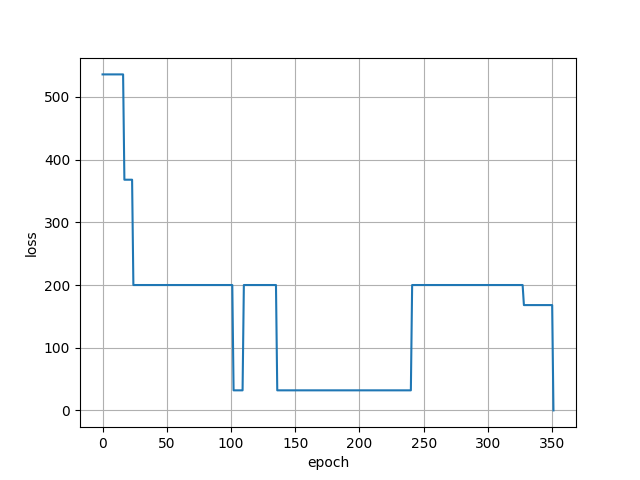

In [152]:
NAME = 'loss_curve'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [153]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1,  0, -1,  0]], dtype=torch.int32) 
 tensor([[0, 0, 0, 0]], dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[-1,  0,  0,  0],
        [ 0, -1,  0,  0],
        [ 0,  1,  1,  0],
        [ 0,  0,  1, -1]], dtype=torch.int32) 
 tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)


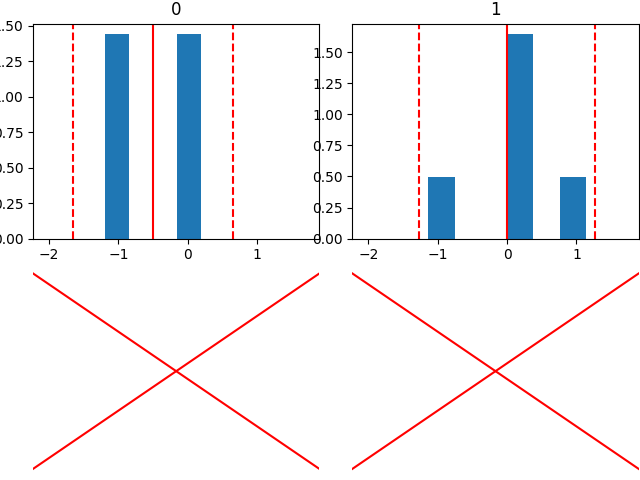

In [154]:
FIG_NAME = "W distribution"
plt.close(FIG_NAME)

data = [layer.W for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

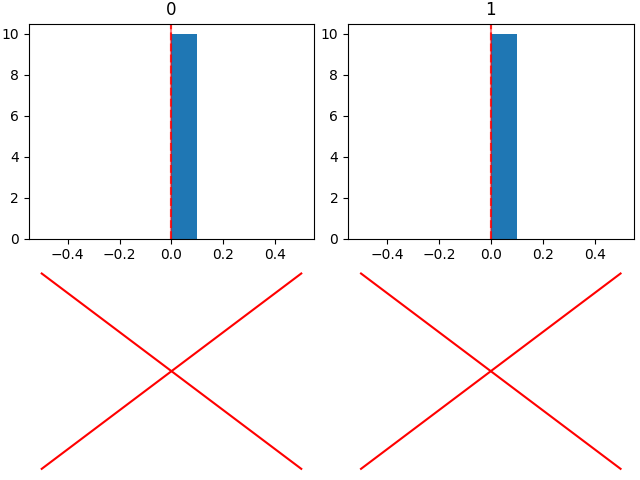

In [155]:

FIG_NAME = "W_grad distribution"
plt.close(FIG_NAME)

data = [layer.W.grad for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-", alpha=0.5)
        ax.axvline(mean+2*std, color="red", ls="--", alpha=0.5)
        ax.axvline(mean-2*std, color="red", ls="--", alpha=0.5)


for ax in axs:
    #ax.set_xlim(min_x, max_x)
    pass
        

fig.tight_layout(pad=0.1)

plt.show()

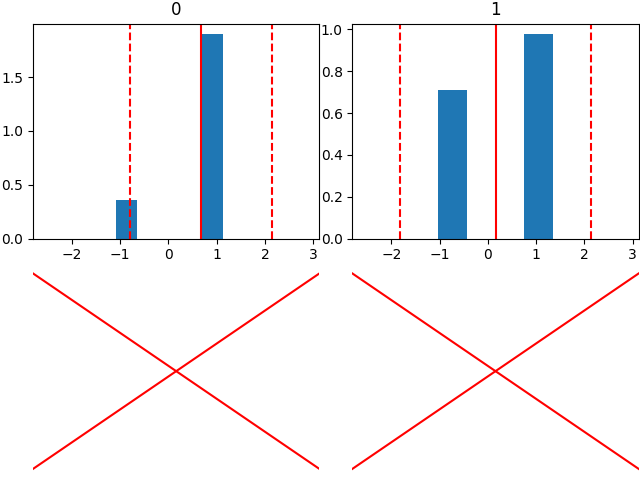

In [156]:
FIG_NAME = "activation distribution"
plt.close(FIG_NAME)

data = TBNN.input.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.flatten().to(torch.float)
        if len(datum_float) > 1:
            mean = datum_float.mean().item()
            std = datum_float.std().item()
        else:
            mean = datum_float[0].item()
            std = 0

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

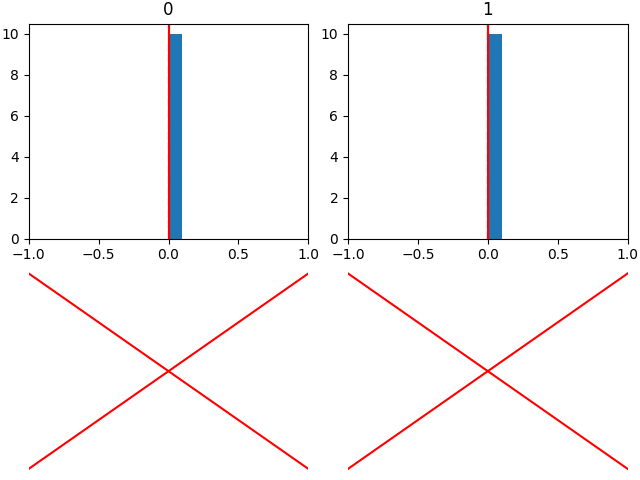

In [157]:

FIG_NAME = "grad distribution"
plt.close(FIG_NAME)

data = TBNN.grad.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.flatten().to(torch.float)
        if len(datum_float) > 1:
            mean = datum_float.mean().item()
            std = datum_float.std().item()
        else:
            mean = datum_float[0].item()
            std = 0

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()